# Image processing assignment #1

**Student**: Aleksandr J. Smoliakov, MIF Data Science, MSc year 1  
**Date**: 2024-10-11

## Image Loading

In the first part of the assignment, we will use the CLI tool `tiffinfo` to investigate the handed-out images.

In [1]:
!tiffinfo -D data/imgset1/Kidney1.tif

TIFF Directory at offset 0x866312 (d3808)
  Subfile Type: (0 = 0x0)
  Image Width: 1120 Image Length: 2508 Image Depth: 1
  Tile Width: 240 Tile Length: 240
  Bits/Sample: 8
  Compression Scheme: JPEG
  Photometric Interpretation: RGB color
  Samples/Pixel: 3
  Planar Configuration: single image plane
  ImageDescription: Aperio Image Library v12.0.15 
18288x40236 [0,100 17927x40136] (240x240) -> 1120x2508 JPEG/RGB Q=92
  JPEG Tables: (574 bytes)


In [2]:
# !tiffinfo -D data/imgset1/*

_[Output has been removed for brevity]_

Evidently, this tool provides metadata about TIFF images, such as their dimensions, compression type, bit depth, etc. The obtained information shows the structure and properties of each image.

Some observations:

* `TMA2-v2.tif` contains subfiles with different dimensions (3102x3102 and 1551x1551), it is a pyramid TIFF.
* `Kidney2_RGB2_20x.svs` has subfiles with different dimensions, it's not clear what they represent.
* All images have the tile size of 240x240 pixels.
* Some images are compressed using LZW, while others are uncompressed JPEG.
* All images are 8-bit, which means they have 256 levels of intensity.
* Some images have 1 sample per pixel (grayscale), while others have 3 samples per pixel.
* Of the images with 3 samples per pixel, some have RGB color space, while others have YCbCr color space.

### Image loading

The next task involves loading images using the `libtiff` library. We will load whole images and sub-rectangles by combining tiles read using the `read_one_tile` function from the TIFF library.

#### Whole image

First, we will load the whole image `Kidney1.tif` and display it.

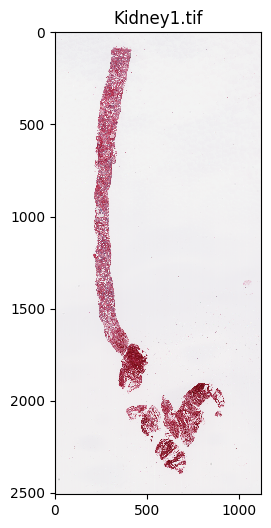

In [3]:
import matplotlib.pyplot as plt
from libtiff import TIFF


plt.figure(figsize=(6, 6))
plt.imshow(
    TIFF.open("data/imgset1/Kidney1.tif").read_image(),
    interpolation="nearest",
    vmin=0,
    vmax=255,
)
plt.title("Kidney1.tif")
plt.show()

#### Sub-rectangles

Next, we will load select sub-rectangles of the image `Kidney1.tif` and display them. We will load the following sub-rectangles:

* Top-left corner (0, 0) with dimensions 240x240.
* Second column, second row (240, 240) with dimensions 240x240.

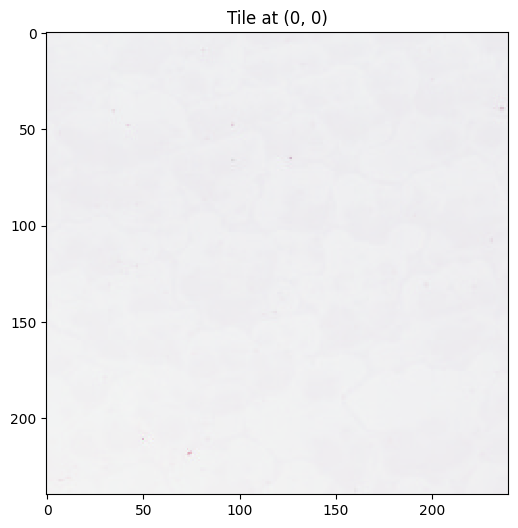

In [4]:
plt.figure(figsize=(6, 6))
plt.imshow(
    TIFF.open("data/imgset1/Kidney1.tif").read_one_tile(0, 0),
    interpolation="nearest",
    vmin=0,
    vmax=255,
)
plt.title("Tile at (0, 0)")
plt.show()

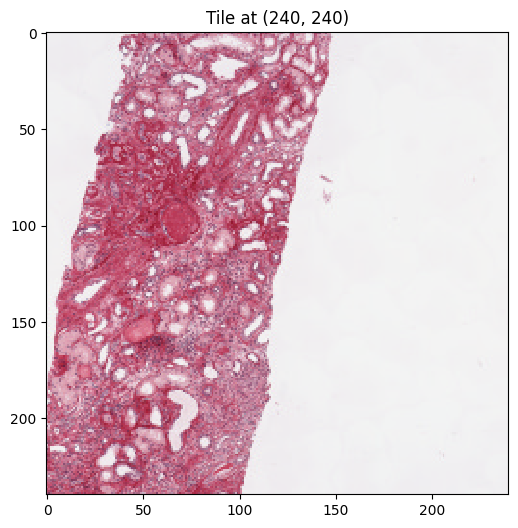

In [5]:
plt.figure(figsize=(6, 6))
plt.imshow(
    TIFF.open("data/imgset1/Kidney1.tif").read_one_tile(240, 240),
    interpolation="nearest",
    vmin=0,
    vmax=255,
)
plt.title("Tile at (240, 240)")
plt.show()

We have defined helper functions `display_grayscale_images`, `display_rgb_images` to display multiple images in a grid.

In [6]:
from python.notebook_utils import display_grayscale_images, display_rgb_images

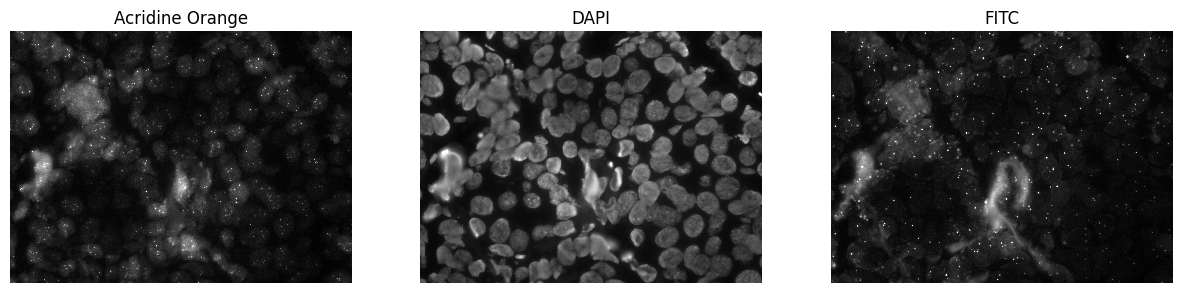

In [7]:
display_grayscale_images(
    [
        "data/imgset1/Region_001_FOV_00041_Acridine_Or_Gray.tif",
        "data/imgset1/Region_001_FOV_00041_DAPI_Gray.tif",
        "data/imgset1/Region_001_FOV_00041_FITC_Gray.tif",
    ],
    titles=["Acridine Orange", "DAPI", "FITC"],
    figsize=(15, 5),
)

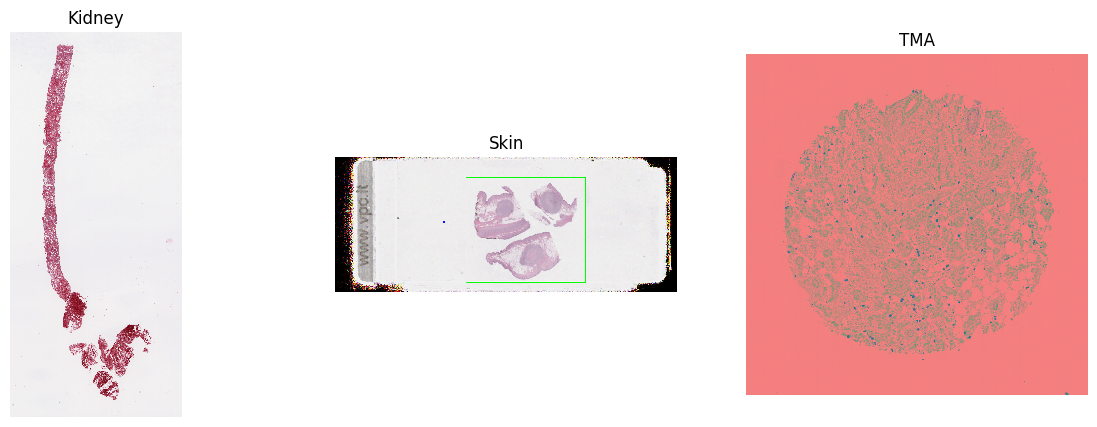

In [8]:
display_rgb_images(
    [
        "data/imgset1/Kidney1.tif",
        "data/imgset1/SkinOverview.tif",
        "data/imgset1/TMA2-v2.tif",
    ],
    titles=["Kidney", "Skin", "TMA"],
    figsize=(15, 5),
)

We visualized these images using `matplotlib`. One possible anomaly is that TMA2-v2.tif is displayed with a pink background. This is possibly due to the fact that the image uses `YCbCr` color space.

### Image combination

Now we shall combine three fluorescence images into one contiguous RGB image and save it to disk.

The combination process involved:

* Loading each grayscale image.
* Stacking the images along the third axis to form an RGB image.
    * Red channel: data/imgset1/Region_001_FOV_00041_Acridine_Or_Gray.tif
    * Green channel: data/imgset1/Region_001_FOV_00041_DAPI_Gray.tif
    * Blue channel: data/imgset1/Region_001_FOV_00041_FITC_Gray.tif
* Saving the resulting RGB image to disk.

In [9]:
!python python/main.py combine \
    data/imgset1/Region_001_FOV_00041_Acridine_Or_Gray.tif \
    data/imgset1/Region_001_FOV_00041_DAPI_Gray.tif \
    data/imgset1/Region_001_FOV_00041_FITC_Gray.tif

Combined image shape: (1024, 1392, 3)
Saved transformed image to output.tif


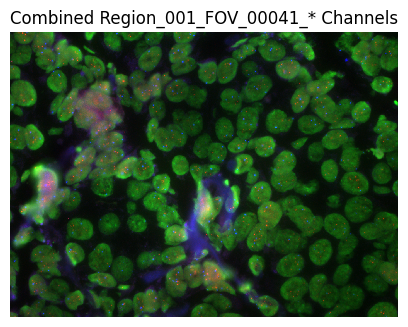

In [10]:
display_rgb_images(
    ["output.tif"],
    titles=["Combined Region_001_FOV_00041_* Channels"],
    figsize=(5, 5),
)

## Intensity Transformations

In the second part of the assignment, we will apply intensity transformations to the images. We will use the following transformations:

* Power-law
* Piece-wise linear transformations
    * Histogram stretching
    * Thresholding
* Histogram calculations
* Histogram normalization

### Power-law

The power law transformation is given by the formula $I_{\text{out}} = I_{\text{in}}^\gamma$, where $\gamma$ is a constant. This transformation is often used to enhance contrast or adjust brightness.

Implementation:

* Input: An 8-bit grayscale image and a value for $\gamma$
* Process: Apply the power law transformation to each pixel's intensity value. Intermediate calculations are done using `float` arithmetic before converting the result back to `uint8`, because the result may well exceed the 8-bit range.
* Output: The transformed image.

Parameter γ:

* γ < 1: Enhances darker regions of the image.
* γ > 1: Enhances brighter regions of the image.

In [65]:
!python python/main.py power-law data/imgset2/Fig0304\(a\)\(breast_digital_Xray\).tif --gamma 0.5 --output-path output1.tif
!python python/main.py power-law data/imgset2/Fig0304\(a\)\(breast_digital_Xray\).tif --gamma 2 --output-path output2.tif

TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.
Powerlaw image shape: (571, 482)
Saved transformed image to output1.tif
TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.
Powerlaw image shape: (571, 482)
Saved transformed image to output2.tif


TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.


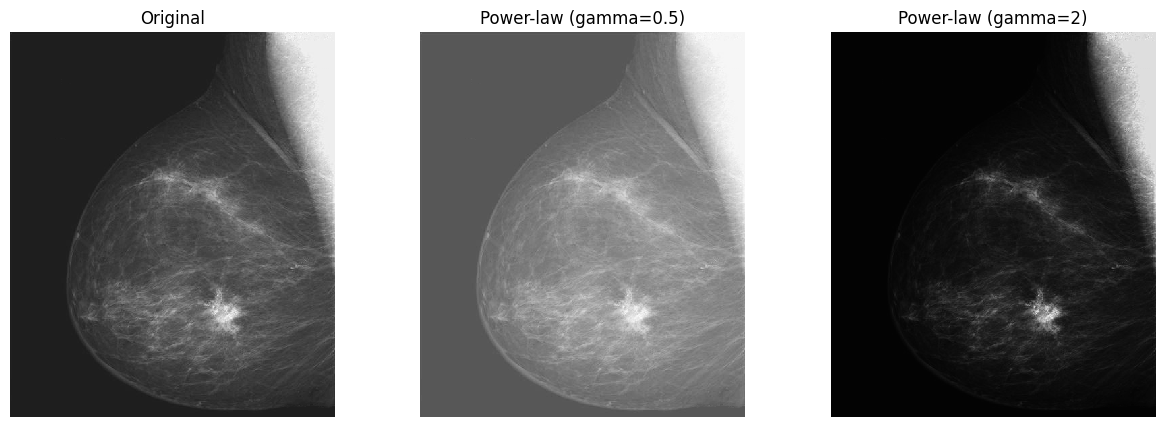

In [12]:
display_grayscale_images(
    [
        "data/imgset2/Fig0304(a)(breast_digital_Xray).tif",
        "output1.tif",
        "output2.tif",
    ],
    titles=["Original", "Power-law (gamma=0.5)", "Power-law (gamma=2)"],
    figsize=(15, 5),
)

As you can see, the power-law transformation with γ=0.5 brightens the dark regions, while γ=2 darkens the darker regions.

### Piece-wise Linear transformations

Piece-wise linear transformations involve applying different linear transformations to different ranges of intensity values. Here we shall demonstrate histogram stretching and thresholding.

#### Histogram stretching

Histogram stretching enhances contrast by expanding the range of intensity values.

Implementation:

* Expand the range of intensity values to enhance contrast.
  * Input: An 8-bit grayscale image.
  * Process: Calculate the minimum and maximum intensity values in the image. Then, apply the following transformation to each pixel's intensity value: $I_{\text{out}} = \frac{I_{\text{in}} - I_{\text{min}}}{I_{\text{max}} - I_{\text{min}}} \times 255$.
    * Intermediate calculations are done using `float` arithmetic, though using `uint16` would also be possible by performing multiplication before division.
  * Output: The transformed image.

In [13]:
!python python/main.py histogram-stretching data/imgset2/Fig0316\(2\)\(2nd_from_top\).tif

TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.
Min value: 91
Max value: 138
Stretched image shape: (500, 500)
Saved transformed image to output.tif


TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.


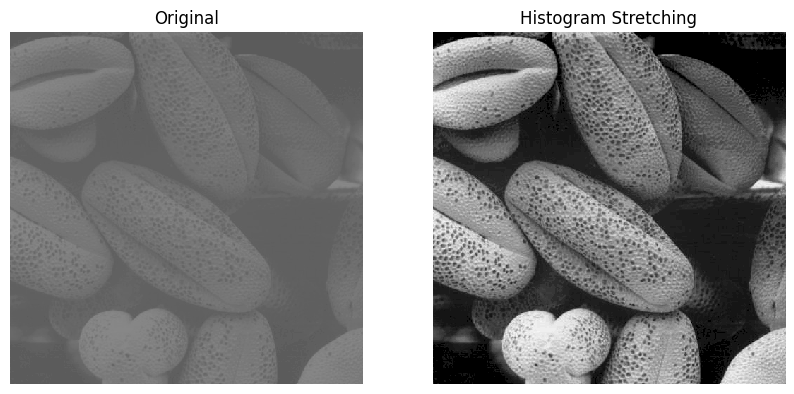

In [14]:
display_grayscale_images(
    [
        "data/imgset2/Fig0316(2)(2nd_from_top).tif",
        "output.tif",
    ],
    titles=["Original", "Histogram Stretching"],
    figsize=(10, 5),
)

As you can see, the histogram stretching transformation strongly enhanced the contrast of the image by expanding the range of intensity values.

#### Thresholding

Thresholding sets pixel values to a minimum or maximum level if they fall above or below a certain threshold.

Implementation:

* Set pixel values to min/max level if they fall above or below a certain threshold.
  * Input: An 8-bit grayscale image and a threshold value.
  * Process: Set pixel values below the threshold to 0 and those above the threshold to 255. Intermediate calculations are done using `int` arithmetic because the result is within the 8-bit range.
  * Output: The thresholded image.

In [15]:
!python python/main.py thresholding data/imgset2/Fig0316\(2\)\(2nd_from_top\).tif --threshold 114

TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.
Thresholded image shape: (500, 500)
Saved transformed image to output.tif


TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.


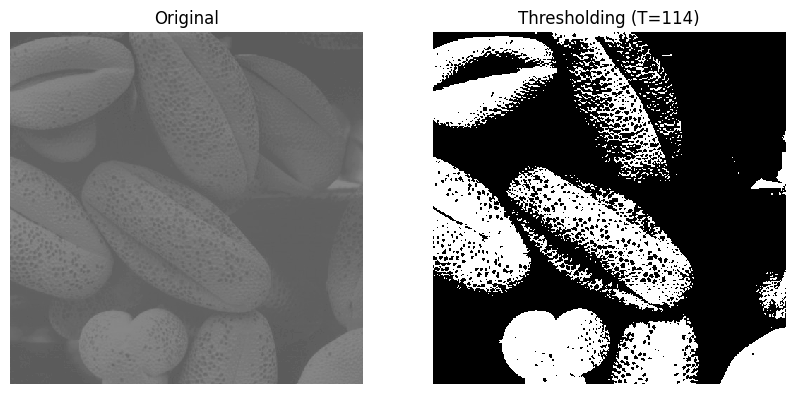

In [16]:
display_grayscale_images(
    [
        "data/imgset2/Fig0316(2)(2nd_from_top).tif",
        "output.tif",
    ],
    titles=["Original", "Thresholding (T=114)"],
    figsize=(10, 5),
)

As you can see, thresholding with a threshold value of 114 resulted in a binary (black & white) image with only two intensity levels.

### Histogram calculation

A histogram represents the frequency distribution of intensity values in an image.

Implementation:

* Input: An 8-bit grayscale image.
* Process: Count the occurrences of each intensity value (0-255) and store them in a frequency array.
* Output: The histogram array.

In [17]:
!python python/main.py histogram-calculation data/imgset2/Fig0304\(a\)\(breast_digital_Xray\).tif

TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.
Histogram shape: (256,)
Histogram: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     1     0     2
     0     0     6    12   704   460 93879  1526  1029  1444   254   322
   399   448   499   579   778  1056  1454  2013  2143  2288  2226  2455
  2400  2389  2309  2351  2354  2383  2347  2253  2306  2651  2883  3060
  2944  2934  3042  2951  2954  2627  2839  2898  2935  2894  2764  2833
  2861  2938  2714  2530  2573  2637  2600  2409  2213  2337  2317  2270
  2162  2011  2065  2088  1858  1922  1953  1865  1715  1500  1566  1467
  1373  1331  1197  1144  1063  1069   883   893   842   799   779   702
   681   613   592   584   515   499   471   438   426   412   339   378
   377   363   348   307   307   286   287   258   258   256   255   224
   217   210   226   228   183   208   192   197   159   162   176 

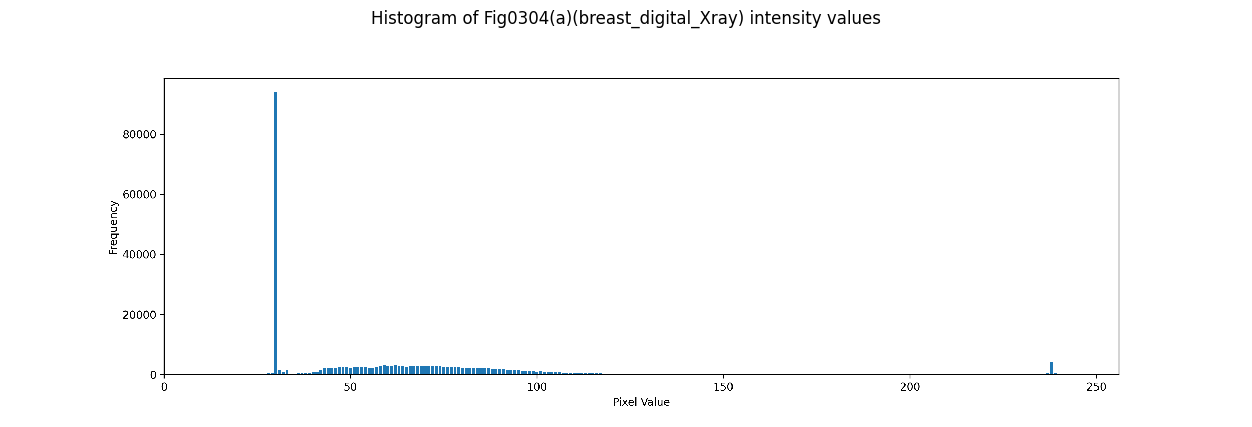

In [18]:
display_rgb_images(
    ["histogram.tif"],
    titles=["Histogram of Fig0304(a)(breast_digital_Xray) intensity values"],
    figsize=(16, 5),
)

You can see the distribution of intensity values. There is a sharp peak around 30, with few values below 30. There is a small peak around 240, with few values above 240. The rest of the values are mostly distributed between 40 and 110.

### Histogram normalization

Histogram normalization adjusts the intensity values to use the full range of possible values (0-255).

Compared with Piece-wise transformation, which manually defines transformations for specific intensity ranges, histogram normalization automatically spreads the intensity values to cover the full range.

In our implementation the number of unique intensity values does not change, because any pixels with the same intensity value will be mapped to the same new value.

Implementation:

* Input: An 8-bit grayscale image.
* Process: Calculate the cumulative distribution function (CDF) from the histogram, then use it to map the original intensities to new values. Intermediate calculations are done using `float` arithmetic before converting the result back to `uint8`, though it would also be possible to use `uint8` and avoid casting.
* Output: The normalized image.

In [19]:
!python python/main.py histogram-normalization data/imgset2/Fig0316\(2\)\(2nd_from_top\).tif

TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.
Normalized image shape: (500, 500)
Saved transformed image to output.tif


TIFFFetchNormalTag: Warning, ASCII value for tag "ImageDescription" does not end in null byte.


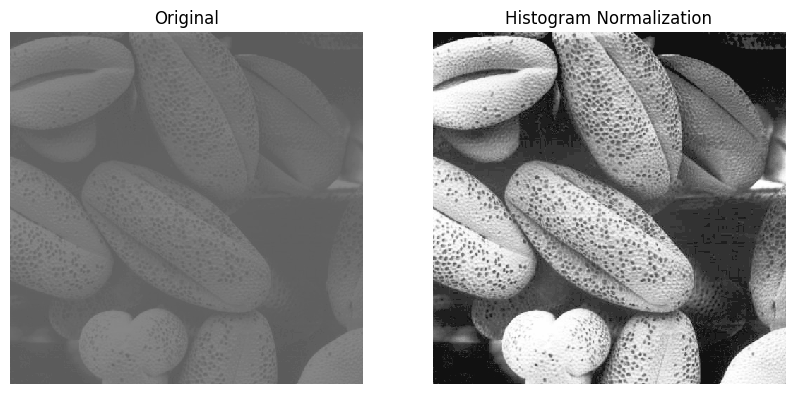

In [20]:
display_grayscale_images(
    [
        "data/imgset2/Fig0316(2)(2nd_from_top).tif",
        "output.tif",
    ],
    titles=["Original", "Histogram Normalization"],
    figsize=(10, 5),
)

## Spatial Filtering and Multistep Image Processing

We will work with 8-bit grayscale images and intermediate results stored as floating-point images.

### Image conversion

We have defined two classes in `image_classes.py`:

* `Image8Bit` for 8-bit images
* `ImageFloat` for floating-point images

In order to avoid saving floating-point images to the disk (which is not allowed) `ImageFloat` does not have a `save` method while `Image8Bit` does.

`Image8Bit` has a method `to_float` that converts the image to floating-point format by dividing the pixel values by 255.0, while `ImageFloat` has a method `to_8bit` that converts the image to 8-bit format by multiplying the pixel values by 255.0 and clipping them to the 0-255 range.

### Image blurring

Implementation:

* Input: An 8-bit grayscale image.
* Process: Apply Averaging convolution to the image.
  * The average filter is a simple low-pass filter that replaces each pixel's intensity value with the average of the pixel values in its neighborhood, as defined by a square kernel of a given size (`kernel-size` parameter).
* Output: The blurred image.

Parameters:

* `kernel-size`: The size of the square kernel used for averaging. A larger kernel size results in more blurring.

In [21]:
!python python/main.py blur data/imgset3/Fig0343\(a\)\(skeleton_orig\).tif --kernel-size 5

Blurred image shape: (800, 500)
Saved image to output.tif


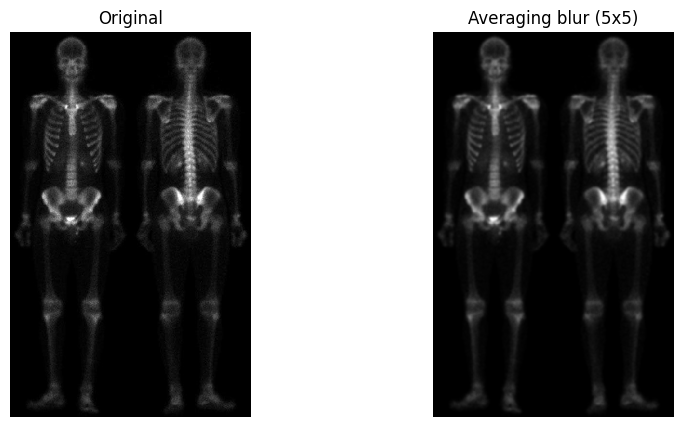

In [22]:
display_grayscale_images(
    [
        "data/imgset3/Fig0343(a)(skeleton_orig).tif",
        "output.tif",
    ],
    titles=["Original", "Averaging blur (5x5)"],
    figsize=(10, 5),
)

As you can see, the right image is blurred.

### Image Sharpening

Implementation:

* Input: An 8-bit grayscale image.
* Process:
  * Laplacian: Apply the axial Laplacian filter to the image. Add the result (scaled by `c`) to the original image.
  * Unsharp: Subtract the blurred image from the original image and add the result to the original image.
    * The blurred image is obtained by applying the average filter to the original image.
* Output: The blurred image.

Parameters:

* `method`: Either `laplacian` or `unsharp`.
* `c`: Sharpening factor. A larger value results in more sharpening.

#### Laplacian

In [71]:
!python python/main.py sharpen laplacian data/imgset3/Fig0338\(a\)\(blurry_moon\).tif --c 4

TIFFReadDirectory: Warning, Unknown field with tag 34016 (0x84e0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34017 (0x84e1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34018 (0x84e2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34019 (0x84e3) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34020 (0x84e4) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34021 (0x84e5) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34022 (0x84e6) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34023 (0x84e7) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34024 (0x84e8) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34025 (0x84e9) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34026 (0x84ea) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34027 (0x84eb) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 3

TIFFReadDirectory: Warning, Unknown field with tag 34016 (0x84e0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34017 (0x84e1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34018 (0x84e2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34019 (0x84e3) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34020 (0x84e4) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34021 (0x84e5) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34022 (0x84e6) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34023 (0x84e7) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34024 (0x84e8) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34025 (0x84e9) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34026 (0x84ea) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34027 (0x84eb) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 3

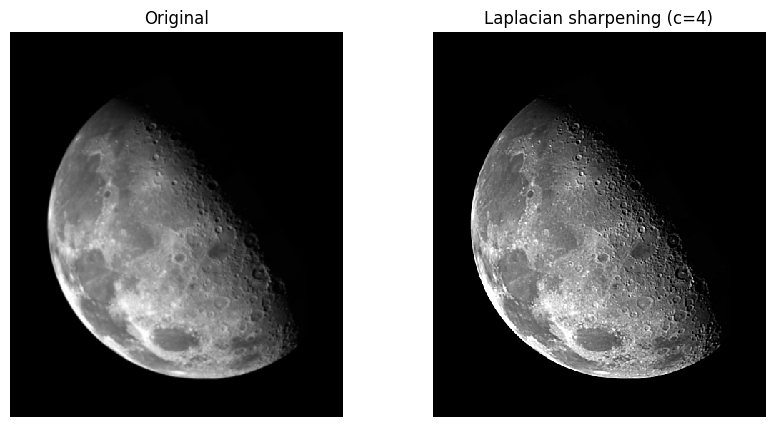

In [56]:
display_grayscale_images(
    [
        "data/imgset3/Fig0338(a)(blurry_moon).tif",
        "output.tif",
    ],
    titles=["Original", "Laplacian sharpening (c=4)"],
    figsize=(10, 5),
)

#### Unsharp

In [63]:
!python python/main.py sharpen unsharp data/imgset3/Fig0338\(a\)\(blurry_moon\).tif --c 2

TIFFReadDirectory: Warning, Unknown field with tag 34016 (0x84e0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34017 (0x84e1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34018 (0x84e2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34019 (0x84e3) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34020 (0x84e4) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34021 (0x84e5) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34022 (0x84e6) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34023 (0x84e7) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34024 (0x84e8) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34025 (0x84e9) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34026 (0x84ea) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34027 (0x84eb) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 3

TIFFReadDirectory: Warning, Unknown field with tag 34016 (0x84e0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34017 (0x84e1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34018 (0x84e2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34019 (0x84e3) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34020 (0x84e4) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34021 (0x84e5) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34022 (0x84e6) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34023 (0x84e7) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34024 (0x84e8) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34025 (0x84e9) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34026 (0x84ea) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34027 (0x84eb) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 3

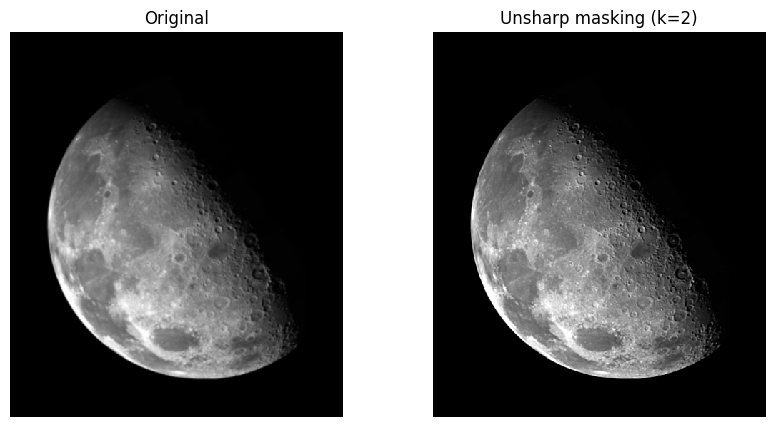

In [64]:
display_grayscale_images(
    [
        "data/imgset3/Fig0338(a)(blurry_moon).tif",
        "output.tif",
    ],
    titles=["Original", "Unsharp masking (k=2)"],
    figsize=(10, 5),
)

### Magnitude of Gradient using Sobel Operators

Implementation:

* Input: An 8-bit grayscale image.
* Process: Apply Sobel operators to the image to calculate the gradient in the x and y directions. Then, calculate the magnitude of the gradient at each pixel. Formula: $G = \sqrt{dx^2 + dy^2}$.
* Output: The blurred image.

In [199]:
!python python/main.py sobel data/imgset3/Fig0333\(a\)\(test_pattern_blurring_orig\).tif

Sobel image shape: (500, 500)
Saved image to output.tif


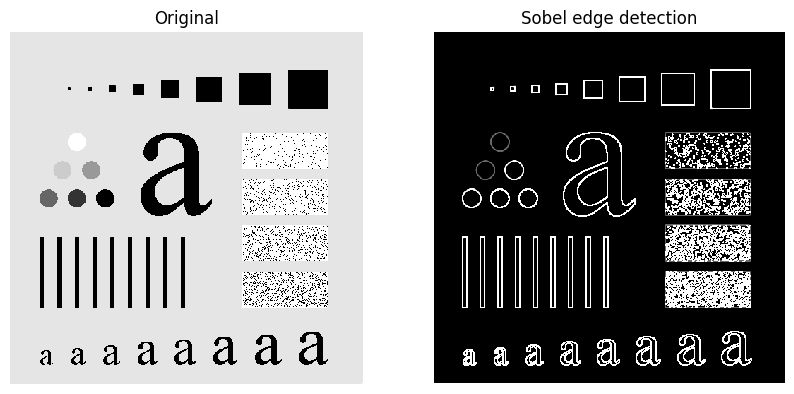

In [201]:
display_grayscale_images(
    [
        "data/imgset3/Fig0333(a)(test_pattern_blurring_orig).tif",
        "output.tif",
    ],
    titles=["Original", "Sobel edge detection"],
    figsize=(10, 5),
)

### Partial derivatives

Implementation:

* Input: An 8-bit grayscale image.
* Process: Apply partial derivative convolution kernels to the image to calculate the gradients in the x and y directions.
* Output: The blurred image.

In [202]:
!python python/main.py apply-kernel derivative_x data/imgset3/Fig0333\(a\)\(test_pattern_blurring_orig\).tif --output-path output_x.tif
!python python/main.py apply-kernel derivative_y data/imgset3/Fig0333\(a\)\(test_pattern_blurring_orig\).tif --output-path output_y.tif
!python python/main.py apply-kernel second_derivative_x data/imgset3/Fig0333\(a\)\(test_pattern_blurring_orig\).tif --output-path output_x2.tif
!python python/main.py apply-kernel second_derivative_y data/imgset3/Fig0333\(a\)\(test_pattern_blurring_orig\).tif --output-path output_y2.tif

Transformed image shape: (500, 500)
Saved image to output_x.tif
Transformed image shape: (500, 500)
Saved image to output_y.tif
Transformed image shape: (500, 500)
Saved image to output_x2.tif
Transformed image shape: (500, 500)
Saved image to output_y2.tif


#### First derivatives

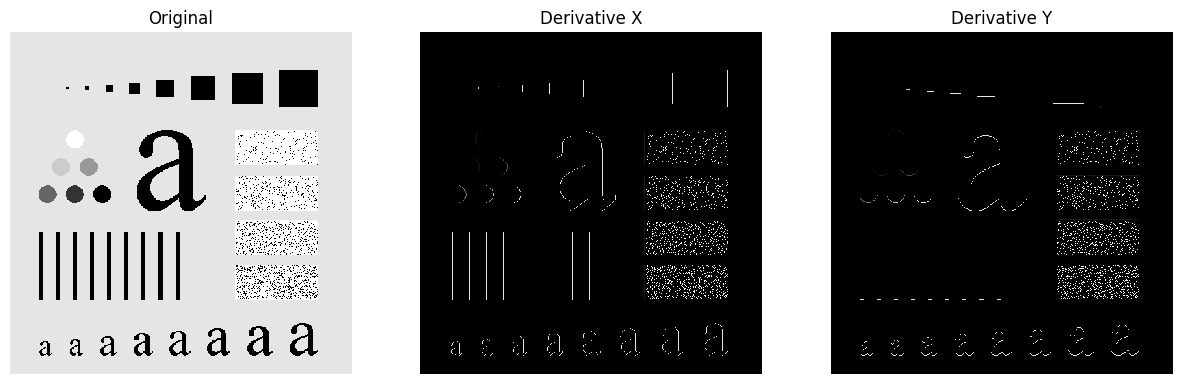

In [203]:
display_grayscale_images(
    [
        "data/imgset3/Fig0333(a)(test_pattern_blurring_orig).tif",
        "output_x.tif",
        "output_y.tif",
    ],
    titles=["Original", "Derivative X", "Derivative Y"],
    figsize=(15, 5),
)

#### Second derivatives

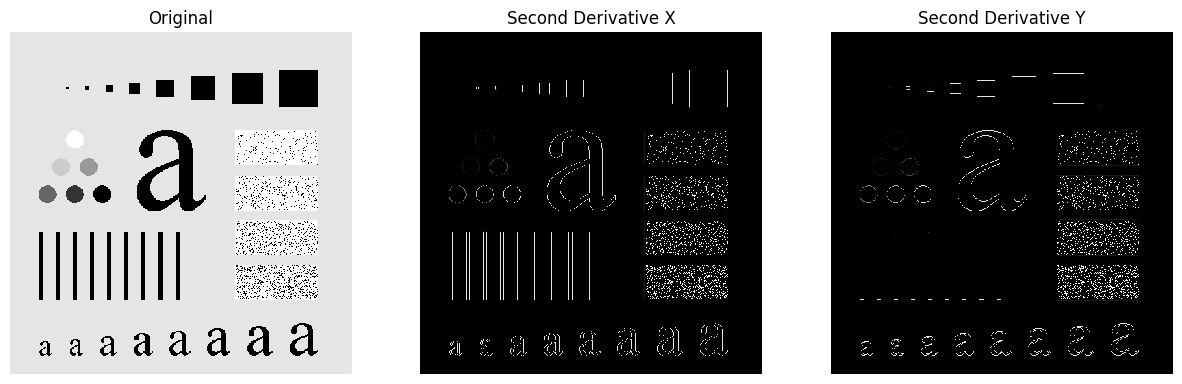

In [204]:
display_grayscale_images(
    [
        "data/imgset3/Fig0333(a)(test_pattern_blurring_orig).tif",
        "output_x2.tif",
        "output_y2.tif",
    ],
    titles=["Original", "Second Derivative X", "Second Derivative Y"],
    figsize=(15, 5),
)